In [52]:
# ================================
# Block 1: Preprocessing
# ================================

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Input, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D

from tensorflow.keras.optimizers import Adam

# Download TSLA stock data
tsla_data = yf.download("TSLA", start="2020-01-01", end="2025-01-01", progress=False)

# Use the 'Close' price as the feature/target
data = tsla_data['Close'].values.reshape(-1, 1)

# Determine train/test split (80% train, 20% test)
train_end = int(len(data) * 0.8)

# Fit scaler on training data only to prevent leakage
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data[:train_end])
data_scaled = scaler.transform(data)

# Create sequences: previous 30 days to predict the next value
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(data_scaled, seq_length)

# Split sequences into training and test sets.
# The training set contains sequences whose target index is < train_end.
X_train = X[:train_end - seq_length]
y_train = y[:train_end - seq_length]
X_test = X[train_end - seq_length:]
y_test = y[train_end - seq_length:]

print("Preprocessing completed.")
print("Training samples:", X_train.shape[0], "Test samples:", X_test.shape[0])


Preprocessing completed.
Training samples: 976 Test samples: 252


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
LSTM Model - Train MSE: 0.0011971489841808888 Test MSE: 0.0016980562419563762


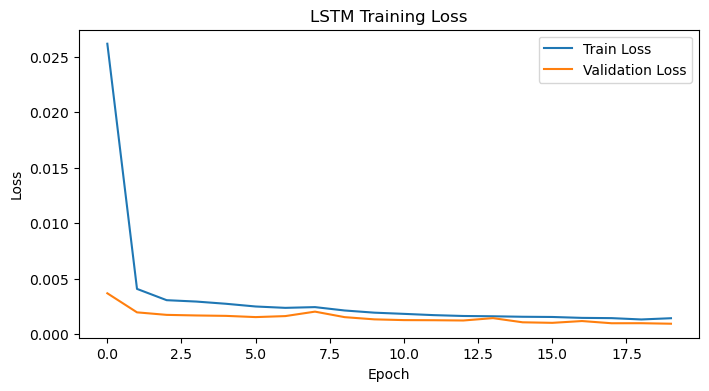

In [53]:
# ================================
# Block 2: LSTM Model
# ================================

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, 
                              validation_split=0.1, verbose=0)

# Make predictions
preds_lstm_train = lstm_model.predict(X_train)
preds_lstm_test = lstm_model.predict(X_test)

# Calculate MSE for training and test sets
mse_lstm_train = mean_squared_error(y_train, preds_lstm_train)
mse_lstm_test = mean_squared_error(y_test, preds_lstm_test)

print("LSTM Model - Train MSE:", mse_lstm_train, "Test MSE:", mse_lstm_test)

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
GRU Model - Train MSE: 0.0006277990724628331 Test MSE: 0.000859866883334838


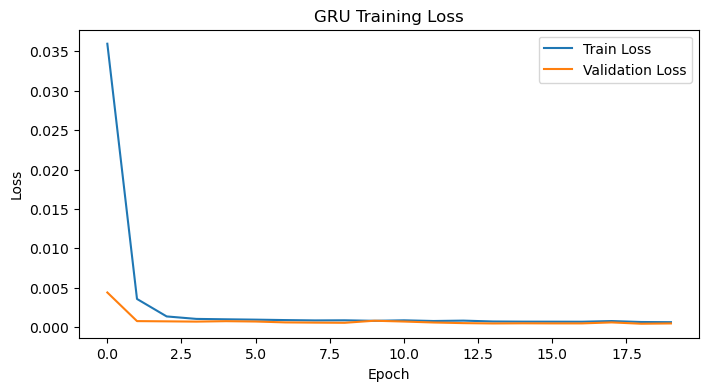

In [54]:
# ================================
# Block 3: GRU Model
# ================================

gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(seq_length, 1)),
    GRU(50),
    Dense(1)
])

gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_history = gru_model.fit(X_train, y_train, epochs=20, batch_size=32, 
                            validation_split=0.1, verbose=0)

# Make predictions
preds_gru_train = gru_model.predict(X_train)
preds_gru_test = gru_model.predict(X_test)

# Calculate MSE
mse_gru_train = mean_squared_error(y_train, preds_gru_train)
mse_gru_test = mean_squared_error(y_test, preds_gru_test)

print("GRU Model - Train MSE:", mse_gru_train, "Test MSE:", mse_gru_test)

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title("GRU Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
CNN LSTM Model - Train MSE: 0.0012546812830970823 Test MSE: 0.001707279686174993


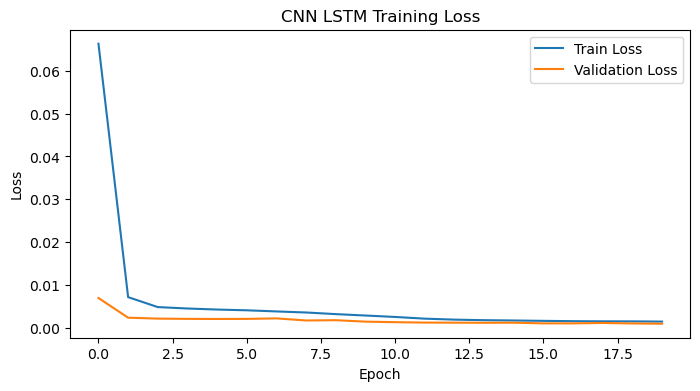

In [55]:
# ================================
# Block 4: CNN LSTM Model
# ================================
# For CNN LSTM, we reshape the input into subsequences.
# Here we split 30 timesteps into 5 subsequences of 6 timesteps each.
subsequences = 5
timesteps = seq_length // subsequences  # 30/5 = 6

X_train_cnn = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))
X_test_cnn = X_test.reshape((X_test.shape[0], subsequences, timesteps, 1))

cnn_lstm_model = Sequential([
    TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'),
                    input_shape=(subsequences, timesteps, 1)),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(50),
    Dense(1)
])

cnn_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
cnn_lstm_history = cnn_lstm_model.fit(X_train_cnn, y_train, epochs=20, batch_size=32, 
                                      validation_split=0.1, verbose=0)

# Make predictions
preds_cnnlstm_train = cnn_lstm_model.predict(X_train_cnn)
preds_cnnlstm_test = cnn_lstm_model.predict(X_test_cnn)

# Calculate MSE
mse_cnnlstm_train = mean_squared_error(y_train, preds_cnnlstm_train)
mse_cnnlstm_test = mean_squared_error(y_test, preds_cnnlstm_test)

print("CNN LSTM Model - Train MSE:", mse_cnnlstm_train, "Test MSE:", mse_cnnlstm_test)

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(cnn_lstm_history.history['loss'], label='Train Loss')
plt.plot(cnn_lstm_history.history['val_loss'], label='Validation Loss')
plt.title("CNN LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Transformer Model - Train MSE: 0.0006454900179445275 Test MSE: 0.0008391761307452016


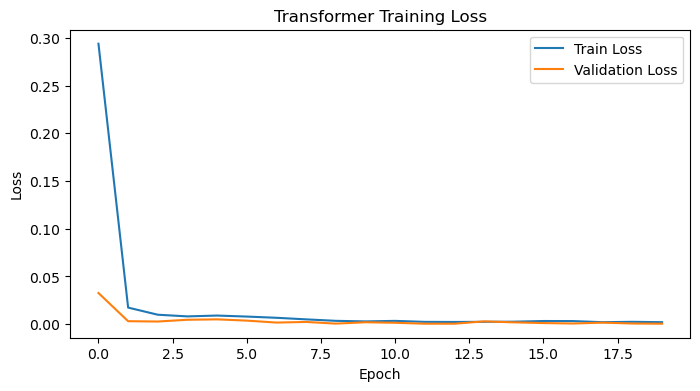

In [56]:
# ================================
# Block 5: Transformer Model
# ================================
# Define a simple Positional Encoding layer and a Transformer encoder block

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Model parameters
d_model = 64
num_heads = 4
ff_dim = 128  # Size of the feed-forward layer

input_layer = Input(shape=(seq_length, 1))
# Project the input to the model dimension
x = Dense(d_model)(input_layer)
# Add positional encoding
x = PositionalEncoding(seq_length, d_model)(x)
# Transformer encoder: multi-head attention + add&norm
attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
attn_output = Dropout(0.1)(attn_output)
out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)
# Feed-forward network
ffn = Sequential([
    Dense(ff_dim, activation='relu'),
    Dense(d_model)
])
ffn_output = ffn(out1)
ffn_output = Dropout(0.1)(ffn_output)
out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
# Global pooling and final output
x = GlobalAveragePooling1D()(out2)
output = Dense(1)(x)

transformer_model = Model(inputs=input_layer, outputs=output)
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
transformer_history = transformer_model.fit(X_train, y_train, epochs=20, batch_size=32, 
                                            validation_split=0.1, verbose=0)

# Make predictions
preds_transformer_train = transformer_model.predict(X_train)
preds_transformer_test = transformer_model.predict(X_test)

# Calculate MSE
mse_transformer_train = mean_squared_error(y_train, preds_transformer_train)
mse_transformer_test = mean_squared_error(y_test, preds_transformer_test)

print("Transformer Model - Train MSE:", mse_transformer_train, "Test MSE:", mse_transformer_test)

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(transformer_history.history['loss'], label='Train Loss')
plt.plot(transformer_history.history['val_loss'], label='Validation Loss')
plt.title("Transformer Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Attention LSTM Model - Train MSE: 0.003422119155920896 Test MSE: 0.005153558001780459


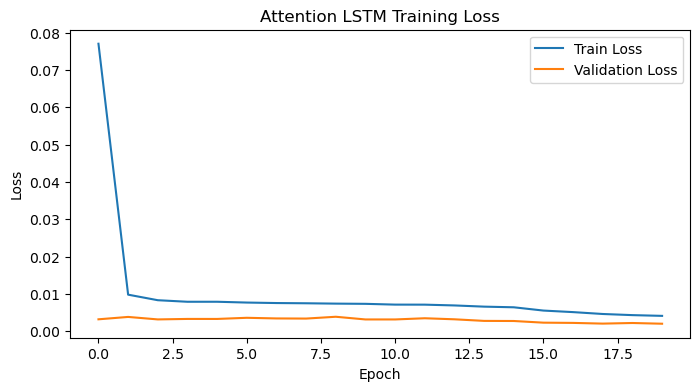

In [57]:
# ================================
# Block 6: Attention LSTM Model
# ================================
# Define a custom Attention layer to use with an LSTM network

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, x):
        # x shape: (batch_size, time_steps, features)
        score = tf.tanh(tf.matmul(x, self.W) + self.b)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * x
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector

# Build the Attention LSTM model
attention_input = Input(shape=(seq_length, 1))
lstm_out = LSTM(50, return_sequences=True)(attention_input)
attn_out = AttentionLayer()(lstm_out)
output = Dense(1)(attn_out)

attention_model = Model(inputs=attention_input, outputs=output)
attention_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
attention_history = attention_model.fit(X_train, y_train, epochs=20, batch_size=32, 
                                        validation_split=0.1, verbose=0)

# Make predictions
preds_attention_train = attention_model.predict(X_train)
preds_attention_test = attention_model.predict(X_test)

# Calculate MSE
mse_attention_train = mean_squared_error(y_train, preds_attention_train)
mse_attention_test = mean_squared_error(y_test, preds_attention_test)

print("Attention LSTM Model - Train MSE:", mse_attention_train, "Test MSE:", mse_attention_test)

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(attention_history.history['loss'], label='Train Loss')
plt.plot(attention_history.history['val_loss'], label='Validation Loss')
plt.title("Attention LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


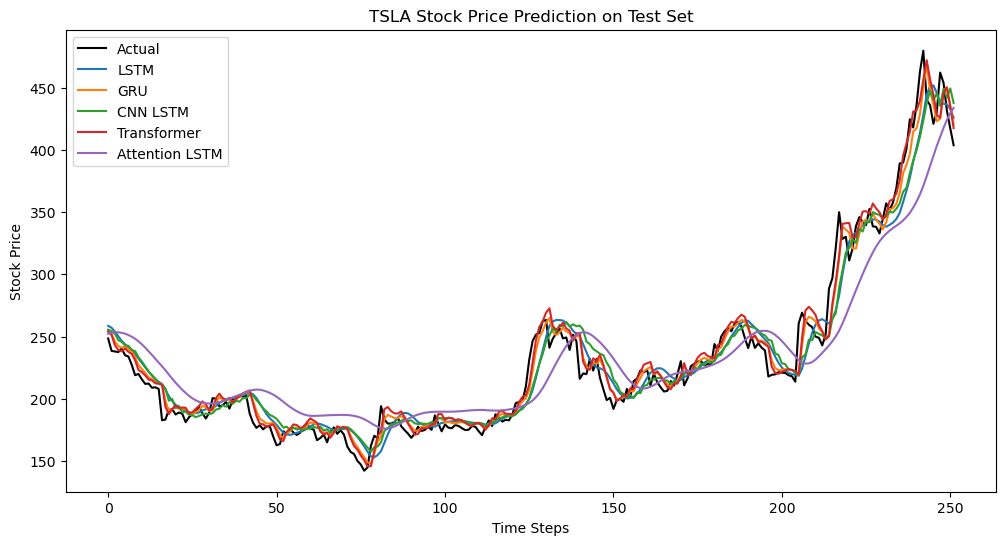

In [60]:
# ================================
# Block 7: Final Plotting of Test Predictions
# ================================
# Inverse-transform the scaled values for a fair comparison

y_test_inv = scaler.inverse_transform(y_test)
preds_lstm_test_inv = scaler.inverse_transform(preds_lstm_test)
preds_gru_test_inv = scaler.inverse_transform(preds_gru_test)
preds_cnnlstm_test_inv = scaler.inverse_transform(preds_cnnlstm_test)
preds_transformer_test_inv = scaler.inverse_transform(preds_transformer_test)
preds_attention_test_inv = scaler.inverse_transform(preds_attention_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual", color='black')
plt.plot(preds_lstm_test_inv, label="LSTM")
plt.plot(preds_gru_test_inv, label="GRU")
plt.plot(preds_cnnlstm_test_inv, label="CNN LSTM")
plt.plot(preds_transformer_test_inv, label="Transformer")
plt.plot(preds_attention_test_inv, label="Attention LSTM")
plt.title("TSLA Stock Price Prediction on Test Set")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
